# 中心性解析（Centrality analysis）
タンパク質相互作用ネットワークを題材に中心性指標とタンパク質の必須性の関係を調査します。具体的に，次のことを行います。

* タンパク質相互作用ネットワークの中心性指標を計算することで重要なタンパク質を同定します。
* 必須タンパク質と非必須タンパク質を中心性指標を比較し，差の統計分析を行います。
* 単一の中心性指標を用いて必須タンパク質を判別します。

networkxの読み込み

In [1]:
import networkx as nx

その他ライブラリ

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.metrics import roc_curve, auc

## 大腸菌のタンパク質相互作用ネットワークの読み込み
* `../data/ecoli_ppi_Hu_etal_2009.txt`
* エッジリスト形式
* Hu P, Janga SC, Babu M, Díaz-Mejía JJ, Butland G, et al. Global functional atlas of Escherichia coli encompassing previously uncharacterized proteins. PLoS Biol. 2009 Apr 28;7(4):e96. doi: [10.1371/journal.pbio.1000096](https://doi.org/10.1371/journal.pbio.100009).

In [3]:
# エッジリストの読み込み
df = pd.read_csv("https://raw.githubusercontent.com/kztakemoto/network-analysis-in-biology/refs/heads/main/data/ecoli_ppi_Hu_etal_2009.txt", sep='\s+', header=None)

# グラフオブジェクトの作成
g = nx.from_pandas_edgelist(df, source=0, target=1)
g = nx.Graph(g)  # 多重エッジを削除
g.remove_edges_from(nx.selfloop_edges(g))  # 自己ループを削除

# 最大連結成分の取得
lcc = max(nx.connected_components(g), key=len)
g = g.subgraph(lcc)

## 中心性指標の計算

In [4]:
# 次数中心性
degree = dict(nx.degree_centrality(g))

# 固有ベクトル中心性
eigen = nx.eigenvector_centrality(g)

# PageRank
page = nx.pagerank(g)

# 近接中心性
closen = nx.closeness_centrality(g)

# 媒介中心性
between = nx.betweenness_centrality(g, normalized=False)

サブグラフ中心性

NetworkXには直接的なサブグラフ中心性の実装がないので用意

In [5]:
def subgraph_centrality(g):
  eig_vals, eig_vecs = np.linalg.eigh(nx.adjacency_matrix(g).todense())
  diag_vals = np.sum((eig_vecs ** 2) * np.exp(eig_vals), axis=1)
  return dict(zip(g.nodes(), diag_vals))

In [6]:
subgraph = subgraph_centrality(g)

後のデータ解析のため、データフレームにまとめておく。

In [7]:
nprop = pd.DataFrame({
  'gene': list(g.nodes()),
  'degree': [degree[n] for n in g.nodes()],
  'eigen': [eigen[n] for n in g.nodes()],
  'page': [page[n] for n in g.nodes()],
  'closen': [closen[n] for n in g.nodes()],
  'between': [between[n] for n in g.nodes()],
  'subgraph': [subgraph[n] for n in g.nodes()]
})

## タンパク質の必須性のデータを読み込む

In [8]:
# 必須性データの読み込み
# 必須（E），非必須（N），不明（u）
ess = pd.read_csv("https://raw.githubusercontent.com/kztakemoto/network-analysis-in-biology/refs/heads/main/data/ecoli_proteins_essentiality_Baba2006MSB.txt", sep=' ')

In [9]:
# データのマージ
d = pd.merge(ess, nprop, on='gene')
# 不明（u）の遺伝子を除外
d = d[d['essential'] != 'u']

## Boxplotの表示

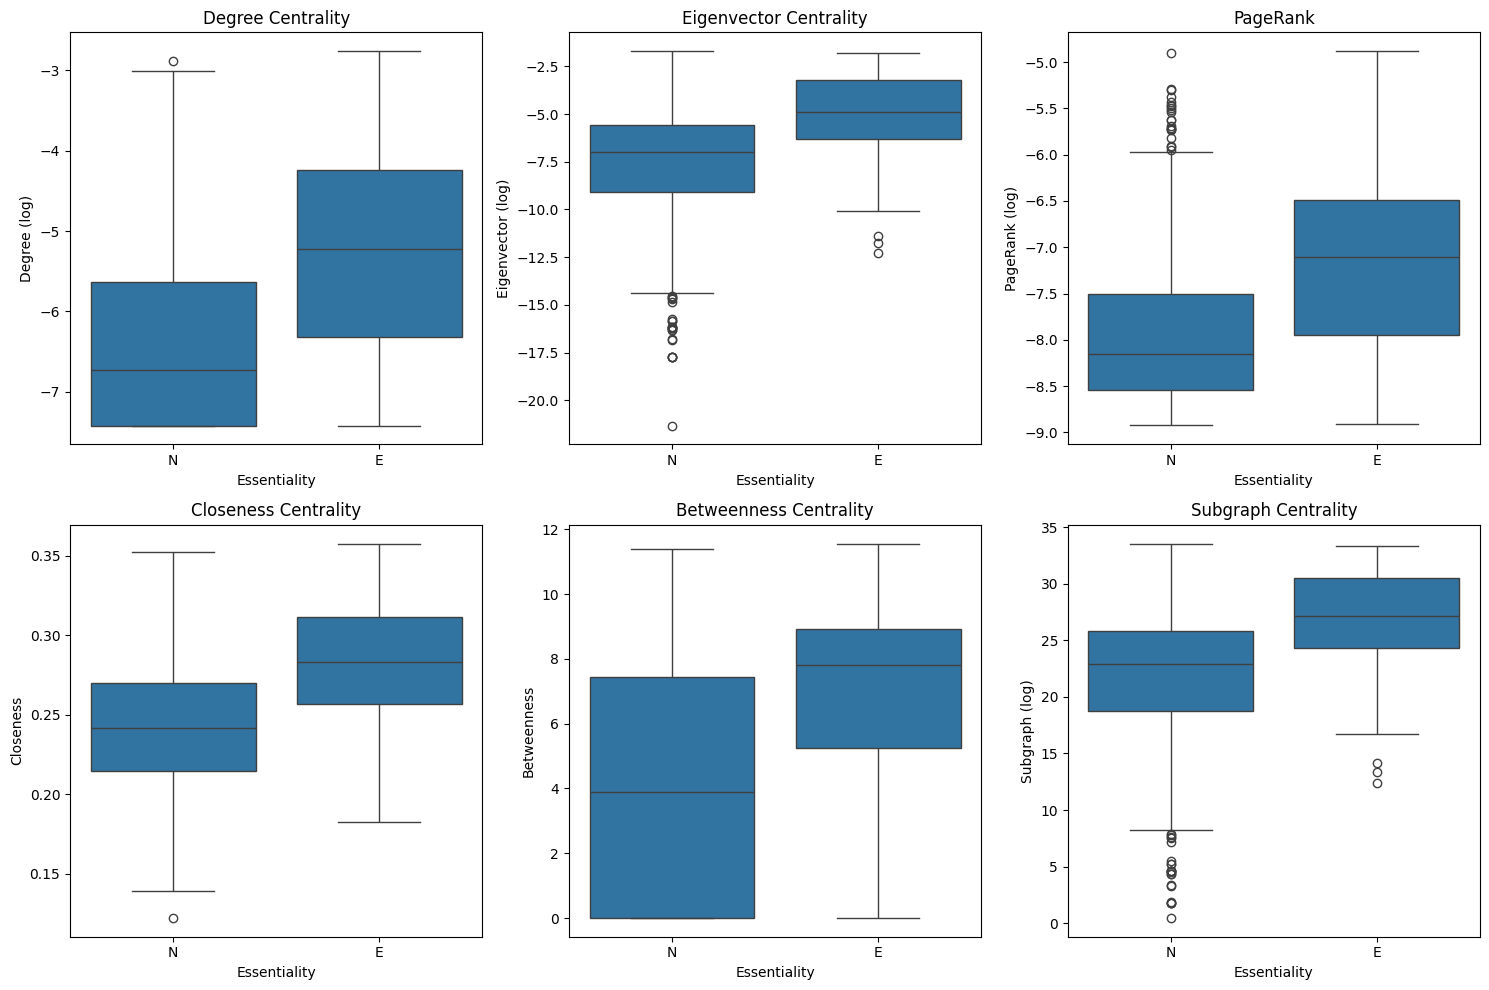

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. 次数中心性
sns.boxplot(data=d, x='essential', y=np.log(d['degree']), ax=axes[0,0])
axes[0,0].set_xlabel('Essentiality')
axes[0,0].set_ylabel('Degree (log)')
axes[0,0].set_title('Degree Centrality')

# 2. 固有ベクトル中心性
sns.boxplot(data=d, x='essential', y=np.log(d['eigen']), ax=axes[0,1])
axes[0,1].set_xlabel('Essentiality')
axes[0,1].set_ylabel('Eigenvector (log)')
axes[0,1].set_title('Eigenvector Centrality')

# 3. PageRank
sns.boxplot(data=d, x='essential', y=np.log(d['page']), ax=axes[0,2])
axes[0,2].set_xlabel('Essentiality')
axes[0,2].set_ylabel('PageRank (log)')
axes[0,2].set_title('PageRank')

# 4. 近接中心性
sns.boxplot(data=d, x='essential', y=d['closen'], ax=axes[1,0])
axes[1,0].set_xlabel('Essentiality')
axes[1,0].set_ylabel('Closeness')
axes[1,0].set_title('Closeness Centrality')

# 5. 媒介中心性
sns.boxplot(data=d, x='essential', y=np.log(d['between']+1), ax=axes[1,1])
axes[1,1].set_xlabel('Essentiality')
axes[1,1].set_ylabel('Betweenness (log)')
axes[1,1].set_title('Betweenness Centrality')

# 6. サブグラフ中心性
sns.boxplot(data=d, x='essential', y=np.log(d['subgraph']), ax=axes[1,2])
axes[1,2].set_xlabel('Essentiality')
axes[1,2].set_ylabel('Subgraph (log)')
axes[1,2].set_title('Subgraph Centrality')

# レイアウトの調整
plt.tight_layout()

## 必須タンパク質と非必須タンパク質の中心性指標の差の検定
下準備

In [11]:
# 必須タンパク質と非必須タンパク質のデータを分離
ess_nprop = d[d['essential'] == 'E']
noness_nprop = d[d['essential'] == 'N']

Wilcoxon検定

In [12]:
metrics = {
    'Degree': 'degree',
    'Eigenvector': 'eigen',
    'PageRank': 'page',
    'Closeness': 'closen',
    'Betweenness': 'between',
    'Subgraph': 'subgraph'
}

for title, metric in metrics.items():
  print(f"{title} centrality")
  print(f"中央値 必須：{ess_nprop[metric].median():.3f} "
        f"非必須：{noness_nprop[metric].median():.3f}")

  # Wilcoxon検定
  stat, pvalue = stats.mannwhitneyu(ess_nprop[metric], noness_nprop[metric], alternative='two-sided')

  print(f"Wilcoxon検定 p値：{pvalue:.2e}")
  print("------------------------------------")

Degree centrality
中央値 必須：0.005 非必須：0.001
Wilcoxon検定 p値：2.44e-30
------------------------------------
Eigenvector centrality
中央値 必須：0.007 非必須：0.001
Wilcoxon検定 p値：1.04e-30
------------------------------------
PageRank centrality
中央値 必須：0.001 非必須：0.000
Wilcoxon検定 p値：1.28e-25
------------------------------------
Closeness centrality
中央値 必須：0.283 非必須：0.242
Wilcoxon検定 p値：3.93e-30
------------------------------------
Betweenness centrality
中央値 必須：2453.932 非必須：47.761
Wilcoxon検定 p値：2.76e-25
------------------------------------
Subgraph centrality
中央値 必須：605614953888.165 非必須：8949452569.137
Wilcoxon検定 p値：1.02e-30
------------------------------------


## 単一の中心性指標を用いて必須タンパク質を判別する

下準備

In [13]:
# 必須性スコアの作成（必須=1, 非必須=0）
ess_score = (d['essential'] == 'E').astype(int)

ROCカーブのプロット

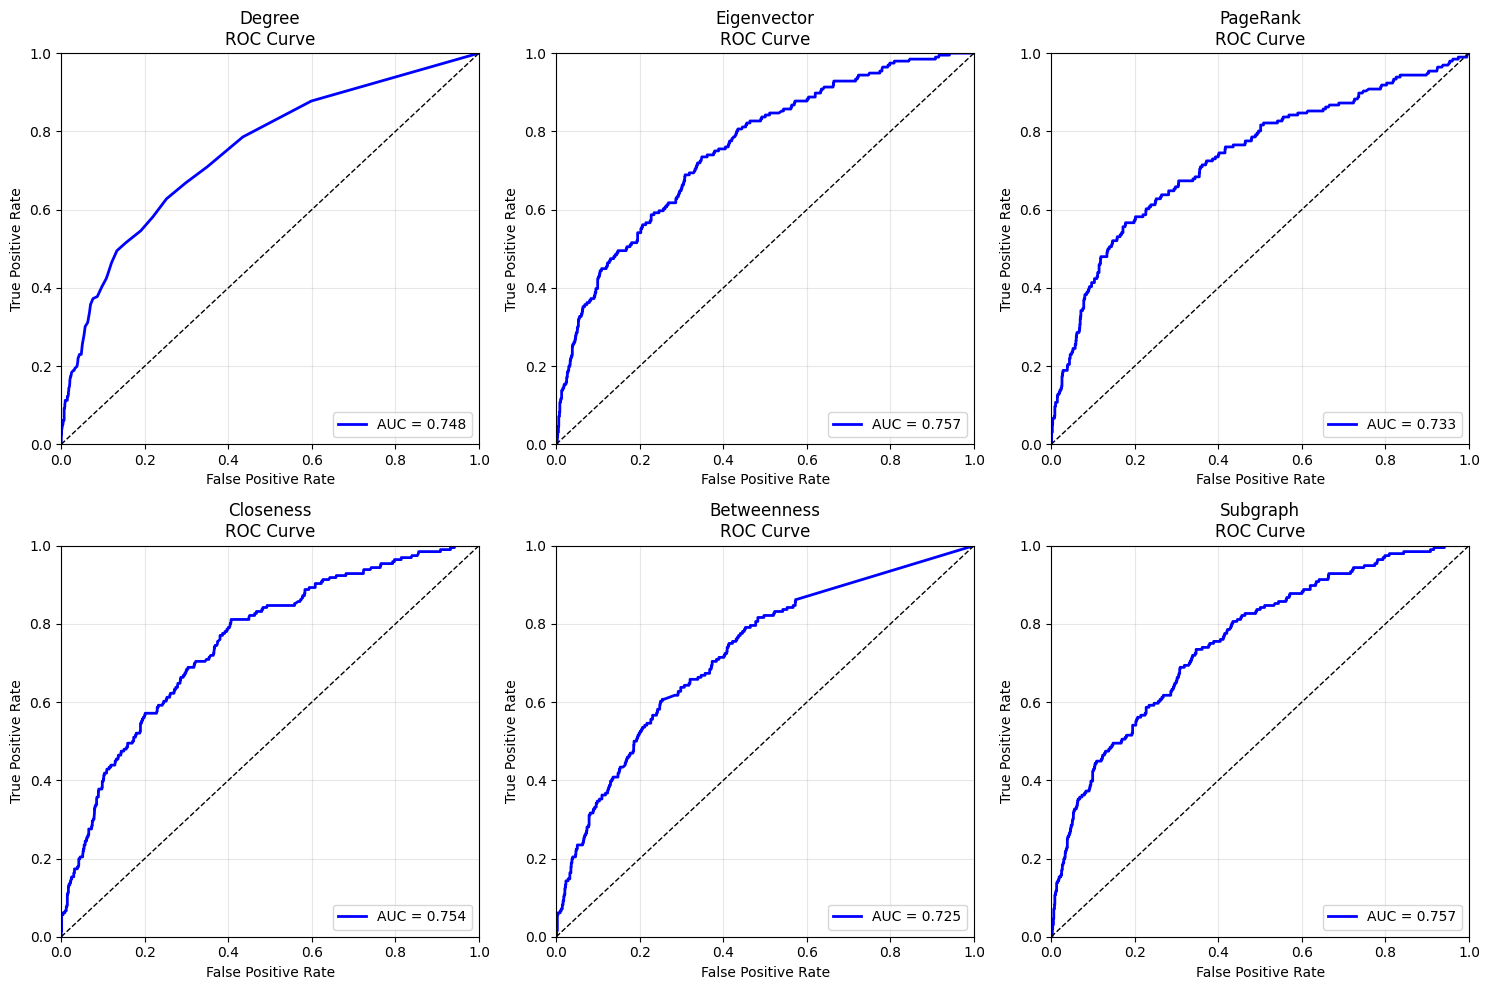

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 各中心性指標についてROC曲線をプロット
for (title, metric), ax in zip(metrics.items(), axes.flat):
    # ROC曲線の計算
    fpr, tpr, _ = roc_curve(ess_score, d[metric])
    roc_auc = auc(fpr, tpr)

    # プロット
    ax.plot(fpr, tpr, color='b', lw=2,
            label=f'AUC = {roc_auc:.3f}')
    ax.plot([0, 1], [0, 1], 'k--', lw=1)  # 対角線

    # グラフの設定
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{title}\nROC Curve')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()